<a href="https://colab.research.google.com/github/JumanaRahim/Nullclass-Internship/blob/main/TASK_2%264.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# ✅ Define a Simple Autoencoder for Colorization
class ColorizationAutoencoder(nn.Module):
    def __init__(self):
        super(ColorizationAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output range [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [8]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Define Dataset Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Smaller size for faster training
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# ✅ Load a Subset of CIFAR-10 (5000 Images for Quick Training)
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
subset_size = 5000
train_subset = torch.utils.data.Subset(trainset, range(subset_size))
trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)


Files already downloaded and verified


In [9]:
model = ColorizationAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 3  # ✅ Keep training short (3 epochs for quick testing)

for epoch in range(num_epochs):
    total_loss = 0.0
    for gray_imgs, _ in trainloader:
        gray_imgs = gray_imgs.to(device)

        # ✅ Convert grayscale to 3-channel grayscale (for loss calculation)
        color_imgs = gray_imgs.repeat(1, 3, 1, 1)

        optimizer.zero_grad()
        outputs = model(gray_imgs)
        loss = criterion(outputs, color_imgs)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(trainloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/3], Loss: 0.0122
Epoch [2/3], Loss: 0.0016
Epoch [3/3], Loss: 0.0006


In [10]:
torch.save(model.state_dict(), "colorization_model.pth")



In [11]:
import cv2
import torch
import numpy as np
from torchvision import transforms

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ColorizationAutoencoder().to(device)
model.load_state_dict(torch.load("colorization_model.pth", map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

def colorize_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_3ch = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    img_tensor = transform(gray_3ch).unsqueeze(0).to(device)

    with torch.no_grad():
        colorized_tensor = model(img_tensor)

    colorized_img = colorized_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    colorized_img = (colorized_img * 255).astype(np.uint8)

    return colorized_img

# Open Webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    colorized_frame = colorize_frame(frame)

    cv2.imshow("Colorized Video", colorized_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()





<ipython-input-11-350cda77f63c>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("colorization_model.pth", map_location=device))


In [13]:
import tkinter as tk
from tkinter import filedialog
import subprocess

# ✅ Use a separate function to initialize Tkinter
def launch_gui():
    root = tk.Tk()
    root.title("Real-Time Video Colorization")
    root.geometry("300x200")

    def start_webcam():
        subprocess.run(["python", "video_colorization.py"])

    btn_webcam = tk.Button(root, text="Start Webcam Colorization", command=start_webcam)
    btn_webcam.pack(pady=20)

    root.mainloop()

# ✅ Run Tkinter inside a separate thread to avoid Jupyter issues
import threading
gui_thread = threading.Thread(target=launch_gui)
gui_thread.start()




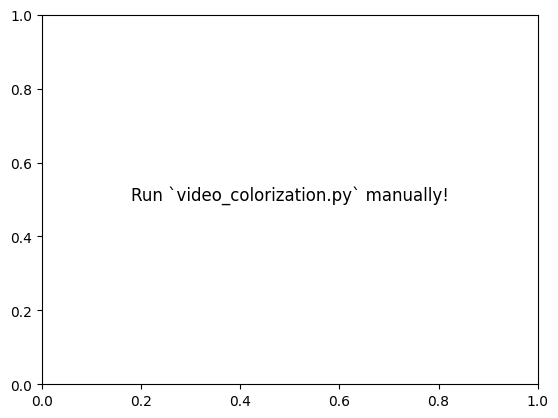

In [14]:
import matplotlib.pyplot as plt

def show_message():
    fig, ax = plt.subplots()
    ax.text(0.5, 0.5, "Run `video_colorization.py` manually!", fontsize=12, ha='center')
    plt.show()

show_message()


In [16]:
import subprocess
subprocess.run(["python", "video_colorization.py"])



CompletedProcess(args=['python', 'video_colorization.py'], returncode=2)

In [17]:
import cv2
print("Run `video_colorization.py` manually!")
cv2.waitKey(0)


Run `video_colorization.py` manually!


-1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np

def evaluate_model():
    all_preds = []
    all_labels = []

    for gray_imgs, color_imgs in trainloader:
        gray_imgs, color_imgs = gray_imgs.to(device), color_imgs.to(device)

        with torch.no_grad():
            outputs = model(gray_imgs)

        pred_classes = (outputs * 255).byte().cpu().numpy().flatten()
        true_classes = (color_imgs * 255).byte().cpu().numpy().flatten()

        all_preds.extend(pred_classes)
        all_labels.extend(true_classes)

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy * 100:.2f}%")

evaluate_model()

